In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
os.chdir(r'C:\Users\ASUS\Data science in neuroimaging\ndslib-main')
from ndslib.data import load_data
abide_data = load_data("abide2")

## Overfitting

In [4]:
features = abide_data.iloc[:, 6:]
phenotypes = abide_data.iloc[:, :6]

y = phenotypes['age'].values

In [14]:
n_features = [5, 10, 20, 50, 100, 200, 500, 1000, 1440]
n_iterations = 10


results = np.zeros((len(n_features), n_iterations))
model = LinearRegression()
for i, n in enumerate(n_features):
    for j in range(n_iterations):
        X = features.sample(n, axis=1)
        model.fit(X, y)
        results[i, j] = model.score(X, y)

Text(0, 0.5, 'Explained variance in age ($R^2$)')

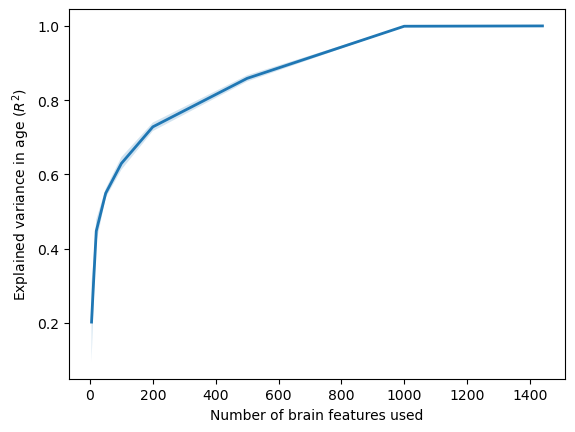

In [18]:
averages = results.mean(1)
fig, ax = plt.subplots()
ax.plot(n_features, averages, linewidth=2)
stds = results.std(1)
ax.fill_between(n_features, averages - stds, averages + stds, alpha=0.2)
ax.set_xlabel("Number of brain features used")
ax.set_ylabel("Explained variance in age ($R^2$)")
# how well (or poorly)those features aremeasured/extracted; howsimple our linearregressionmodel is

## Cross Validation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=0.5)

The practice of fitting our estimator to the training data, and then evaluating its performance on the test data is called cross-validation,

In [15]:
est = LinearRegression()
est.fit(X_train, y_train)
print(f"R^2 in training sample: ", est.score(X_train, y_train))
print(f"R^2 in test sample: ", est.score(X_test, y_test))

R^2 in training sample:  1.0
R^2 in test sample:  -1.2039211961892624


The R2 value is negative, implying that our model is predictively worthless! If you are used to computing R2by taking the square of a correlation coefficient, you might think an R2 value below zeromust be an error, but it is not. The standard definition of R2 as the coefficient of determination is one minus the ratio of the model mean squared errors (MSE) to the variance ofthe data. This allows arbitrarily large negative values because the MSE can be larger thanthe variance if the model is a sufficiently poor fit. Intuitively, we can have an estimator thatis so bad, we would have been better off just using the mean of the new data as our prediction, in which case the MSE would be identical to the variance, based on the definition ofthe variance, and R2 = 0.

In our case, even if we think 500 subjects is a lot (as we well might, if we areused to working with small MRI samples), we still have far more features (1,440).
If our model is overfitting because it has too many features and not enough trainingdata, a simple way to mitigate overfitting should be to use fewer features. 

In [19]:
X = features.sample(200, axis='columns', random_state=99)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=99)
est.fit(X_train, y_train)
print(f"R^2 in training sample: ", est.score(X_train, y_train))
print(f"R^2 in test sample: ", est.score(X_test, y_test))

R^2 in training sample:  0.7915613296581259
R^2 in test sample:  0.4576792069129737


### K-Fold Cross-Validation

if we use all of our data to trainthe model, our estimate of the model’s true (i.e., out-of-sample) predictive performance islikely to be heavily biased. Conversely, ifwesplit our data intoseparate training and testingsubsets, we get a less biased estimate of the model’s true performance, but the cost is thatour model will not perform as well because we are giving it less data to learn from

In [23]:
est = LinearRegression()
k = 5
r2_cv = cross_val_score(est, X, y, cv=k)
print("Individual fold scores:", r2_cv)
print(f"\nMean cross-validated R^2: ", np.mean(r2_cv))

Individual fold scores: [0.60389708 0.53795077 0.56791833 0.56837218 0.55742804]

Mean cross-validated R^2:  0.5671132813920216


### Learning Curve

If we want to get deeperinsights into a model’s behavior, it is helpful to observe the way it responds when we systematically vary the size and nature of the data, the number and type of features, and themodel hyperparameters.

In [40]:
from sklearn.model_selection import learning_curve
train_sizes = [100, 200, 400, 800]
est = LinearRegression()
X_subset = X.sample(100, axis=1, random_state=100)
results = learning_curve(est, X_subset, y, train_sizes=train_sizes,
cv=5, shuffle=True)
sizes, train_scores, test_scores = results

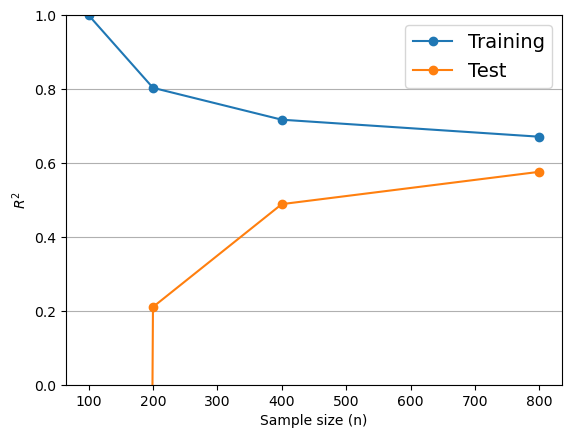

In [41]:
train_mean = train_scores.mean(1)
test_mean = test_scores.mean(1)
fig, ax = plt.subplots()
ax.plot(sizes, train_mean, 'o-', label='Training')
ax.plot(sizes, test_mean, 'o-', label='Test');
ax.grid(True, axis='y')
ax.legend(fontsize=14)
ax.set_ylim(0, 1)
ax.set_xlabel('Sample size (n)')
ax.set_ylabel('$R^2$');

We learn several things from this plot. First, our linear regression estimator overfitswith small samples: R2 is near one in the training sample, but is essentially zero in thetest sample. Second, R2 in the test sample improves monotonically as the training data setgets larger. This is a general rule: on average, a model’s out-of-sample performance shouldonly get better as it is trained on more data. Third, note that the training and test curvesnever converge, even with the largest sample we have available. 

Exercise

We have looked at the relationship between training datasetsize andmodel performance.Here, you will add another dimension to the picture, and try to get a qualitative senseof how our training and validation curves vary as a function of model complexity. Inthis case, we will operationalize this as the number of predictors our linear regressionestimator gets to use.
Use the ABIDE II data to predict age given three different sizes of feature sets: five features, thirty features, and 100 features, which you select at random. Once again, evaluateperformance for sample sizes ranging from 100 to 800.
Does our ability to predict age vary depending on how many features we use? Do thecharacteristics of overfitting change with the sample size?
We will return to a discussion of model complexity in the final chapter of this part ofthe book (chapter 22) when we consider the complexity of deep learning models withmany thousands of parameters that can be adjusted.

In [85]:
X_subset_1 = X.sample(5, axis=1, random_state=100)
X_subset_2 = X.sample(30, axis=1, random_state=100)
X_subset_3 = X.sample(100, axis=1, random_state=100)

train_sizes, train_scores_1, test_scores_1 = learning_curve(est, X_subset_1, y, train_sizes=train_sizes, cv=5, shuffle=True)
train_sizes , train_scores_2, test_scores_2 = learning_curve(est, X_subset_2, y, train_sizes=train_sizes, cv=5, shuffle=True)
train_sizes , train_scores_3, test_scores_3 = learning_curve(est, X_subset_3, y, train_sizes=train_sizes, cv=5, shuffle=True)

# Compute means
train_mean_1 = train_scores_1.mean(axis=1)
test_mean_1 = test_scores_1.mean(axis=1)

train_mean_2 = train_scores_2.mean(axis=1)
test_mean_2 = test_scores_2.mean(axis=1)

train_mean_3 = train_scores_3.mean(axis=1)
test_mean_3 = test_scores_3.mean(axis=1)


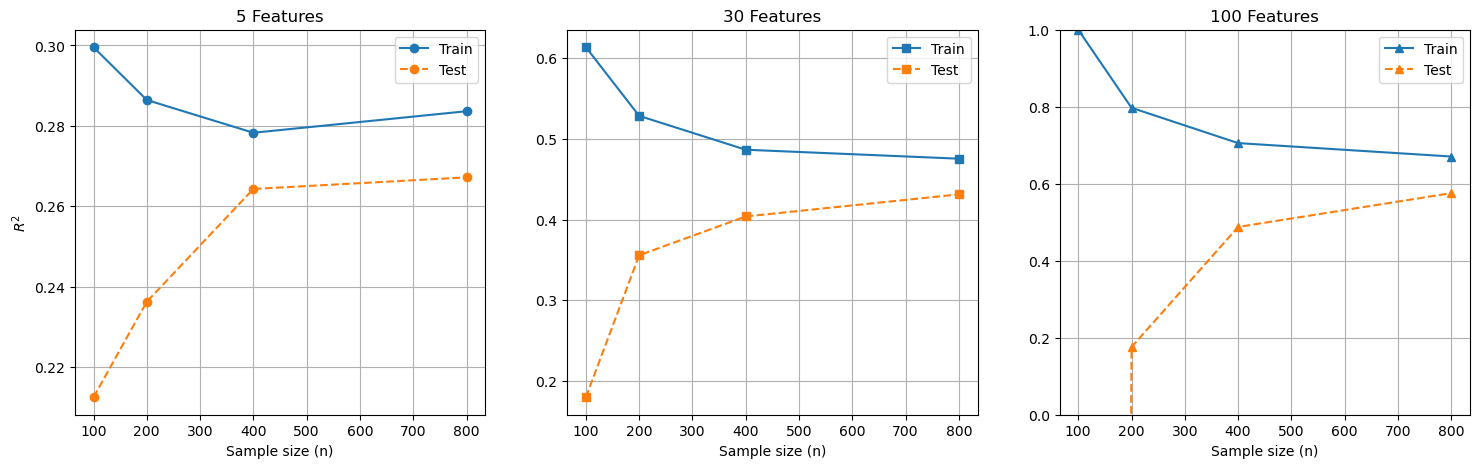

In [86]:
# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1
axs[0].plot(train_sizes, train_mean_1, 'o-', label='Train')
axs[0].plot(train_sizes, test_mean_1, 'o--', label='Test')
axs[0].set_title('5 Features')
axs[0].set_xlabel('Sample size (n)')
axs[0].set_ylabel('$R^2$')
axs[0].grid(True)
axs[0].legend()

# Subplot 2
axs[1].plot(train_sizes, train_mean_2, 's-', label='Train')
axs[1].plot(train_sizes, test_mean_2, 's--', label='Test')
axs[1].set_title('30 Features')
axs[1].set_xlabel('Sample size (n)')
axs[1].grid(True)
axs[1].legend()

# Subplot 3
axs[2].plot(train_sizes, train_mean_3, '^-', label='Train')
axs[2].plot(train_sizes, test_mean_3, '^--', label='Test')
axs[2].set_title('100 Features')
axs[2].set_xlabel('Sample size (n)')
axs[2].set_ylim(0, 1)
axs[2].grid(True)
axs[2].legend()

## Model Selection

Regularization

The principle of introducing background knowledge into ourmodelto improve predictions and prevent overfitting is known in machine learning and statistics as regularization.When we say we are using a regularized estimator, what we are typically saying is that wehavetaken an existing estimator (e.g., an ordinary least-squares (OLS) estimator) and constrained its behavior with additional information, so that it is biased toward certain partsof the parameter space. for example: We could highlight a few parameters that could best train the model instead of huge parameter space.

There is nothing specialabout OLS. Well, it is kind of special in that it always minimizes the squared error in ourtraining sample. But as we have already seen, we usually care about minimizing test error,not training error (plus, sometimes we do not want to quantify error in terms of a leastsquares criterion). So ifwe can get our hands on an estimator that is biased relative to OLS,but tends to reduce error in the test data set, we probably still want to use it, even if it doesnot reduce error in the training data quite as well as OLS.
It turns out that there are many such estimators. One of the most widely used classof regularized estimators for regression problems is penalized regression. 

In [94]:
from ndslib.viz import plot_coef_path
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

In [109]:
number_of_features = 200
X = scale(features.sample(number_of_features, axis=1, random_state=99))
y = phenotypes['age']

In [111]:
alpha = np.logspace(-3, 1, 100)

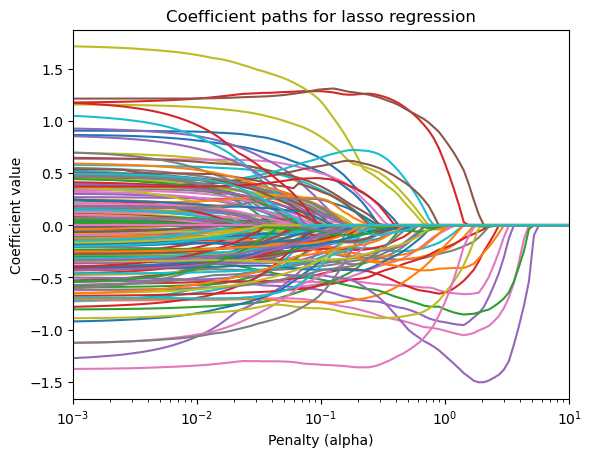

In [113]:
ax = plot_coef_path(Lasso, X, y, alpha, max_iter=2000)
ax.set_title("Coefficient paths for lasso regression")
ax.set_xlim(1e-3, 10);

We are using 200 randomly selected features (from the full setof 1,440) as predictors, so there are 200 lines. The x-axis displays the penalty parameterused for lasso estimation; the y-axis displays the resulting value of the coefficients. Noticehow, at a certain point (around alpha = 0.01), coefficients start to disappear. Theyare not just small; they are gone (i.e., they have been shrunk to zero). This built-in featureselection is a very useful property of the lasso. 

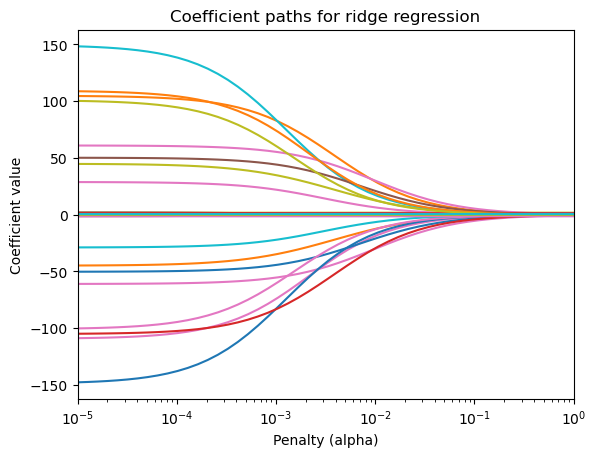

In [115]:
from sklearn.linear_model import Ridge
# Coefficient paths for ridge regression, predicting age from 30 features
alpha = np.logspace(-5, 5, 100)
ax = plot_coef_path(Ridge, X, y, alpha)
ax.set_title("Coefficient paths for ridge regression")
ax.set_xlim(1e-5, 1);

 If the process(es) that generated ourdata are sparse (or at least, have a good sparse approximation), meaning, a few of ourfeatures make very large contributions and the rest do not matter much, then lasso regression will tend to perform better. If the data-generating process is dense, i.e., lots of factorsmake small contributions to the outcomes, then ridge regression will tend to performbetter.

(0.001, 10)

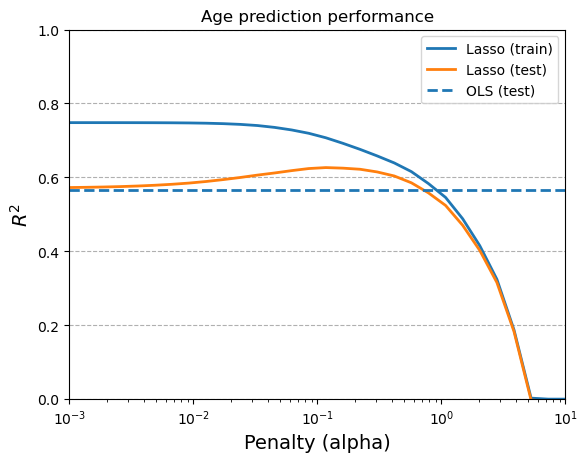

In [121]:
from sklearn.model_selection import validation_curve, cross_val_score
from sklearn.linear_model import LinearRegression
from ndslib.viz import plot_train_test

x_range = np.logspace(-3, 1, 30)

train_scores, test_scores = validation_curve(
Lasso(max_iter=5000), X, y, param_name='alpha',
param_range=x_range, cv=5, scoring='r2')

ols_r2 = cross_val_score(
LinearRegression(), X, y, scoring='r2', cv=5).mean()

ax = plot_train_test(
x_range, train_scores, test_scores, 'Lasso',
hlines={'OLS (test)': ols_r2})
ax.set_title("Age prediction performance")
ax.set_xlim(1e-3, 10)

validation_curve is very similar to the learning_curvewe have seen before, except that instead of systematically varying the data set size, we systematically vary one of the estimator’s parameters 

R2 in the test data set is highest within a specific range of alpha values.This optimum will vary across data sets, so you will almost always need to tune the alphaparameter (e.g., using a validation curve like the one shown in the previous example) toget the best performance out of your model. This extra degree of complexity in the modelselection process is one of the reasons you might not want to always opt for a penalizedversion of OLS, even if you think it can improve your predictions. If you muck things upand pick the wrong penalty, your predictions could be way worse than OLS!

### Random Forest

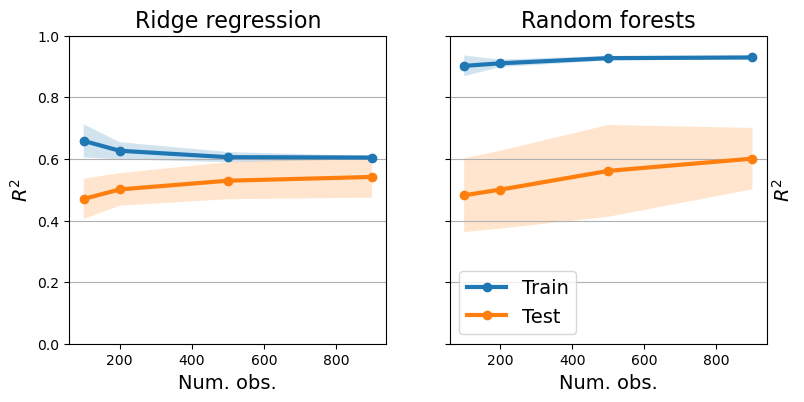

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from ndslib.viz import plot_learning_curves

number_of_features = 50
alpha = 10
number_of_trees_in_forest = 10
selector = SelectKBest(f_regression, k = number_of_features)
X = selector.fit_transform(features, y)
estimators = [Ridge(alpha), RandomForestRegressor(number_of_trees_in_forest)]
labels = ["Ridge regression", "Random forests"]
plot_learning_curves(estimators, [X, X], y, [100, 200, 500, 900], labels)

In [136]:
X.shape

(1004, 50)

In [138]:
y.shape

(1004,)

### Interpreting random forests

Unlike regression-based methods, decision trees (and hence random forests) do not havelinear coefficients. Instead, we can obtain feature importances, which tell us how importanteach feature is to the overall prediction (more important features are better at reducinguncertainty, and occur closer to the root of the tree). Let’s randomlysample thirty featuresand work with those. After fitting, we will print out the names of the ten most importantfeatures.

In [142]:
rf = RandomForestRegressor(100)
X = features.sample(30, axis=1)
rf.fit(X, y)

print(pd.Series(
rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10))

fsCT_L_9m_ROI        0.241070
fsVol_L_MBelt_ROI    0.166225
fsVol_L_23c_ROI      0.066697
fsCT_L_47l_ROI       0.053499
fsArea_R_STGa_ROI    0.043695
fsCT_R_PCV_ROI       0.031569
fsArea_R_PHA1_ROI    0.027960
fsCT_L_PSL_ROI       0.025439
fsArea_L_3a_ROI      0.024983
fsVol_L_LO3_ROI      0.023556
dtype: float64


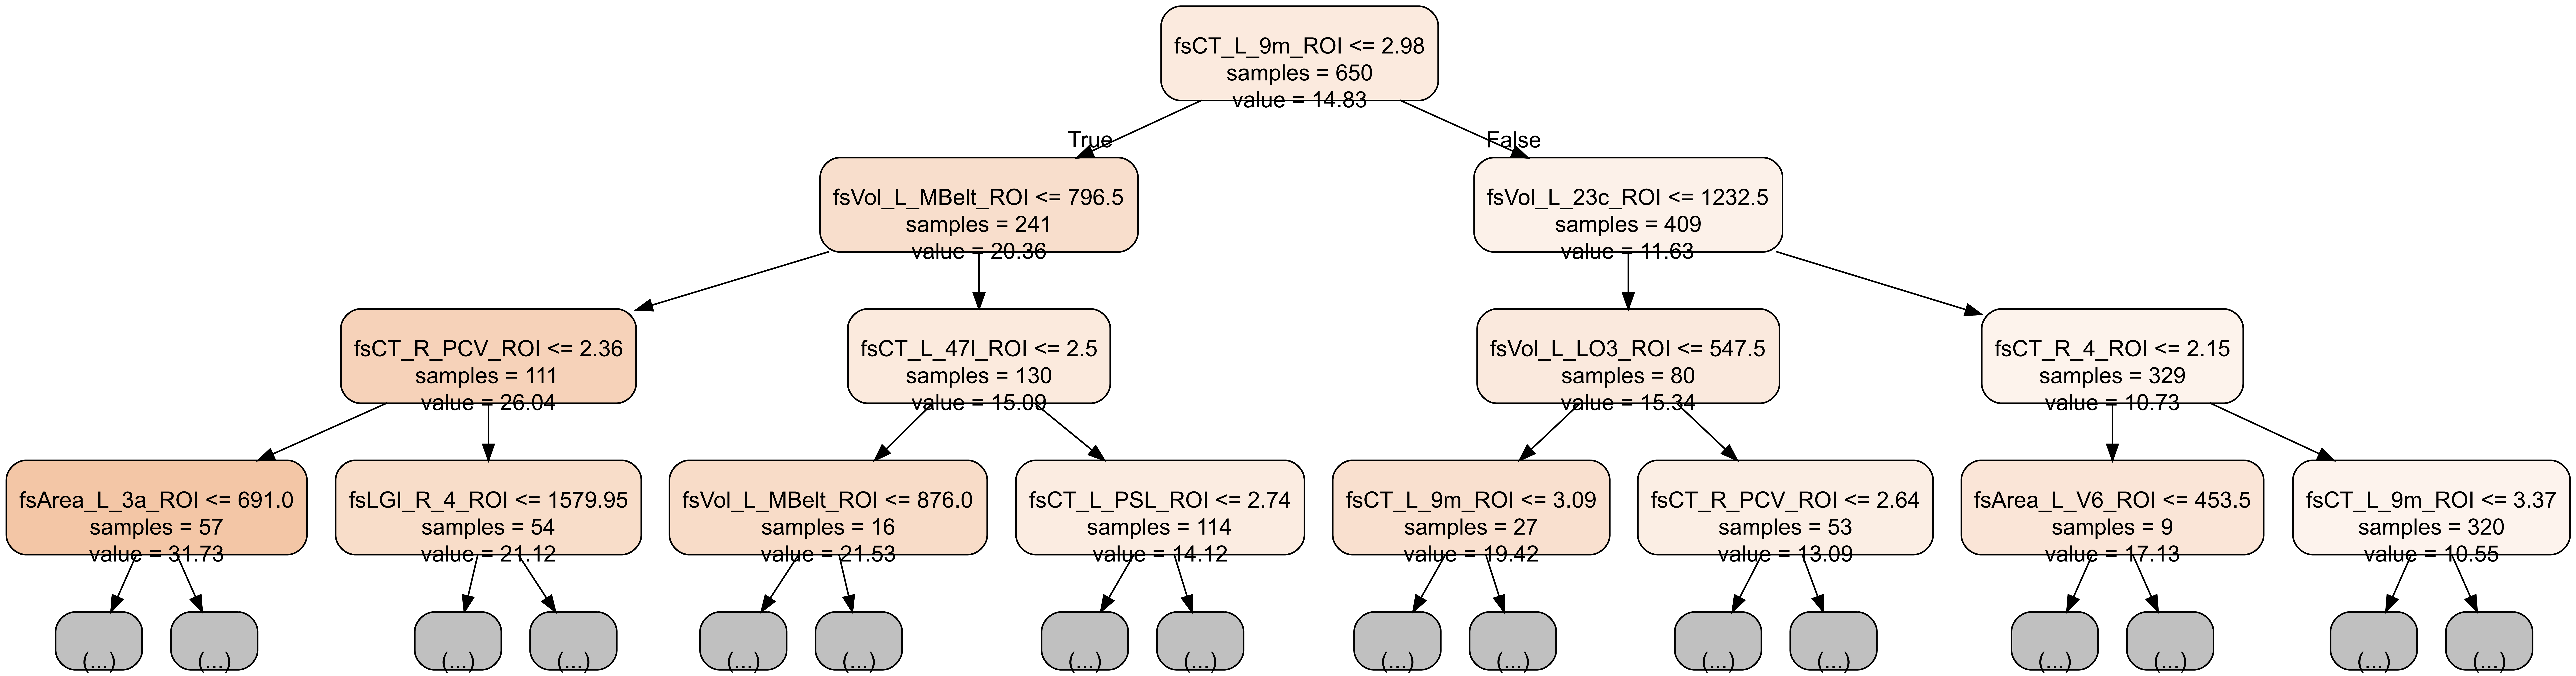

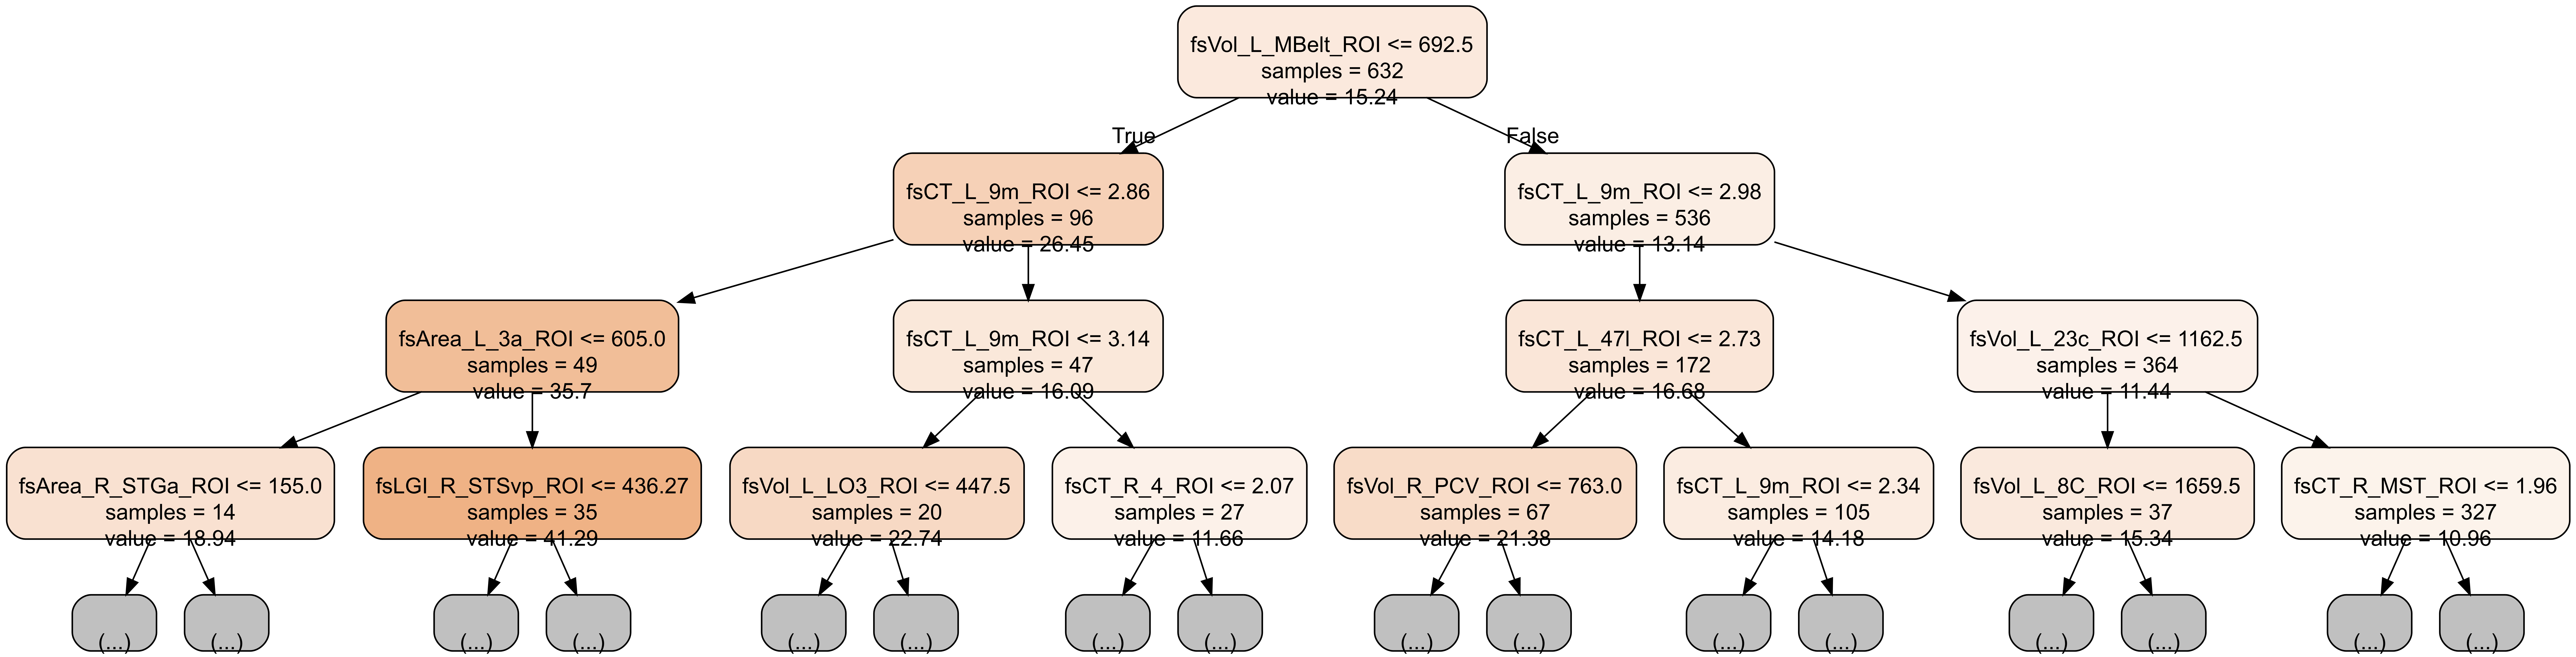

In [144]:
from ndslib.viz import plot_graphviz_tree
plot_graphviz_tree(rf.estimators_[0], X.columns)
plot_graphviz_tree(rf.estimators_[1], X.columns)